<img src='https://repository-images.githubusercontent.com/121802384/c355bb80-7d42-11e9-9e0e-4729609f9fbc' alt='WRF-Hydro Logo' width="15%"/>

# Lesson 5 - Land surface experiments

## Overview
In [Lesson 4](Lesson-4-run-options.ipynb) we experimented with different initial and boundary conditions (precipitation). 

In this lesson, we experiment with different terrain physics options as well as manipulate a few parameters to evaluate impacts on streamflow. [Click here](https://ral.ucar.edu/sites/default/files/public/TerraingRouting_GroundWater.pdf) for reference material on terrain routing and groundwater in WRF-Hydro. 

**NOTE: If you have not completed Lessons 1 through 4, please stop and do so now.**

### Compiling WRF-Hydro
Below are the commands to compile WRF-Hydro. We are doing a quick short-cut to edit the setEnvar.sh to make sure HYDRO_D and SPATIAL_SOIL are both active. See [Lesson 1](Lesson-1-compile.ipynb) if you have any questions on these settings.

**NOTE: You only need to do these steps if you do not already have a compiled binary. If you do, you can skip the compile steps.**

In [ ]:
%%bash
# Change to the trunk/NDHMS directory and configure for gfort
cd ~/wrf-hydro-training/wrf_hydro_nwm_public/trunk/NDHMS/
./configure 2

# Make a copy of the template environment variable file, setEnvars.sh
cp ~/wrf-hydro-training/wrf_hydro_nwm_public/trunk/NDHMS/template/setEnvar.sh \
~/wrf-hydro-training/wrf_hydro_nwm_public/trunk/NDHMS/setEnvar.sh

# Edit setEnvar.sh to turn on debug (HYDRO_D=1) and spatial soils (SPATIAL_SOIL=1)
sed -i -e 's#export HYDRO_D=0#export HYDRO_D=1#g' ~/wrf-hydro-training/wrf_hydro_nwm_public/trunk/NDHMS/setEnvar.sh
sed -i -e 's#export SPATIAL_SOIL=0#export SPATIAL_SOIL=1#g' ~/wrf-hydro-training/wrf_hydro_nwm_public/trunk/NDHMS/setEnvar.sh

# Compile the code
./compile_offline_NoahMP.sh setEnvar.sh >> compile.log 2>&1

# Check to make sure it completed successfully and confirm the correct compile-time options were set.
tail -13 ~/wrf-hydro-training/wrf_hydro_nwm_public/trunk/NDHMS/compile.log

## Experiment with terrain routing options

### Background
In most global and regional land surface models, model cells are simulated as independent columns and "runoff" is interpreted as excess surface and subsurface water that is "scraped" from each cell after vertical infiltration and drainage processes complete. WRF-Hydro adds functionality to allow this excess water to instead move laterally around the land surface based on topographic and head gradients. WRF-Hydro can explicitly represent overland flow processes, where infiltration and saturation excess water propagates over the surface through a diffusive wave formulation. In addition, WRF-Hydro includes shallow subsurface flow, allowing saturated soil water to move from cell to cell through a Boussinesq approximation. For more detailed information refer to [WRF-Hydro V5 Technical Description](https://ral.ucar.edu/sites/default/files/public/WRF-HydroV5TechnicalDescription.pdf). 

### Objective
Experiment with lateral flow physics options, then compare hydrographs with and without terrain routing processes active.

### Step 1: Create and run first baseline simulation
As in Lesson 4, we will create a template directory to use for the terrain physics experiments.

**Step 1a: Create a template run directory**

In [69]:
%%bash
# Make a new directory for our baseline simulation
mkdir -p ~/wrf-hydro-training/output/lesson5/run_gridded_template

# Copy our model files to the simulation directory
cp ~/wrf-hydro-training/wrf_hydro_nwm_public/trunk/NDHMS/Run/*.TBL \
~/wrf-hydro-training/output/lesson5/run_gridded_template
cp ~/wrf-hydro-training/wrf_hydro_nwm_public/trunk/NDHMS/Run/wrf_hydro.exe \
~/wrf-hydro-training/output/lesson5/run_gridded_template

# Create symbolic links to large domain files
cp -as $HOME/wrf-hydro-training/example_case/FORCING \
~/wrf-hydro-training/output/lesson5/run_gridded_template
cp -as $HOME/wrf-hydro-training/example_case/Gridded_no_lakes/DOMAIN \
~/wrf-hydro-training/output/lesson5/run_gridded_template
cp -as $HOME/wrf-hydro-training/example_case/Gridded_no_lakes/RESTART \
~/wrf-hydro-training/output/lesson5/run_gridded_template

# Copy namelist files
cp ~/wrf-hydro-training/example_case/Gridded_no_lakes/namelist.hrldas \
~/wrf-hydro-training/output/lesson5/run_gridded_template
cp ~/wrf-hydro-training/example_case/Gridded_no_lakes/hydro.namelist \
~/wrf-hydro-training/output/lesson5/run_gridded_template

**Step 1b: Now make a copy of the template directory and run the baseline simulation**

First, we remind ourselves what we are running as a baseline. Note in particular that `OVRTSWCRT=1` and `SUBRTSWCRT=1`, meaning that both overland and subsurface flow routing options are active.

In [70]:
%%bash

# Make a copy of the template directory for the baseline run
cp -r ~/wrf-hydro-training/output/lesson5/run_gridded_template \
~/wrf-hydro-training/output/lesson5/run_gridded_baseline

# View the hydro.namelist settings
cat ~/wrf-hydro-training/output/lesson5/run_gridded_baseline/hydro.namelist

&HYDRO_nlist
!!!! ---------------------- SYSTEM COUPLING ----------------------- !!!!

! Specify what is being coupled:  1=HRLDAS (offline Noah-LSM), 2=WRF, 3=NASA/LIS, 4=CLM
sys_cpl = 1

!!!! ------------------- MODEL INPUT DATA FILES ------------------- !!!!

! Specify land surface model gridded input data file (e.g.: "geo_em.d01.nc")
GEO_STATIC_FLNM = "./DOMAIN/geo_em.d01.nc"

! Specify the high-resolution routing terrain input data file (e.g.: "Fulldom_hires.nc")
GEO_FINEGRID_FLNM = "./DOMAIN/Fulldom_hires.nc"

! Specify the spatial hydro parameters file (e.g.: "hydro2dtbl.nc")
! If you specify a filename and the file does not exist, it will be created for you.
HYDROTBL_F = "./DOMAIN/hydro2dtbl.nc"

! Specify spatial metadata file for land surface grid. (e.g.: "GEOGRID_LDASOUT_Spatial_Metadata.nc")
LAND_SPATIAL_META_FLNM = "./DOMAIN/GEOGRID_LDASOUT_Spatial_Metadata.nc"

! Specify the name of the restart file if starting from restart...comment out with '!' if not...
RESTART_FILE  = 

Now run the baseline model simulation as-is.

In [71]:
%%bash

# Run the simulation
cd ~/wrf-hydro-training/output/lesson5/run_gridded_baseline
mpirun -np 2 ./wrf_hydro.exe >> run.log 2>&1

Check that the simulation finished successfully

In [72]:
%%bash

tail -1 ~/wrf-hydro-training/output/lesson5/run_gridded_baseline/diag_hydro.00000

 The model finished successfully.......


### Step 2: Create and run the "overland routing off" simulation
We will run the same experiment as the above baseline run, but with the overland routing module turned off.

**Step 2a: Create a new run directory**

We first create a `run_overland_routing_off` directory from the template.

In [73]:
%%bash

cp -r ~/wrf-hydro-training/output/lesson5/run_gridded_template \
~/wrf-hydro-training/output/lesson5/run_overland_routing_off

We will make one modification to `hydro.namelist` to turn off the overland routing modules. 

**Step 2b: Edit the `hydro.namelist` file**

For this experiment, we will set the *OVRTSWCRT* physics option to 0 in the [hydro.namelist](../output/lesson5/run_overland_routing_off/hydro.namelist), which deactivates overland terrain routing modules. 

```
! Switch to activate surface overland flow routing...(0=no, 1=yes)
OVRTSWCRT = 0
```

**Step 2c: Run the simulation and make sure it finishes successfully**

In [74]:
%%bash

cd ~/wrf-hydro-training/output/lesson5/run_overland_routing_off
mpirun -np 2 ./wrf_hydro.exe >> run.log 2>&1

Check that the simulation finished successfully

In [ ]:
%%bash

tail -1 ~/wrf-hydro-training/output/lesson5/run_overland_routing_off/diag_hydro.00000

### Step 3: Create and run the "no terrain routing" simulation
Now we run an experiment with all terrain routing options turned off. This will approximate a standard column physics configuration.

**Step 3a: Create a new run directory**

We first create a `run_no_terrain_routing` directory from the template.

In [77]:
%%bash

cp -r ~/wrf-hydro-training/output/lesson5/run_gridded_template \
~/wrf-hydro-training/output/lesson5/run_no_terrain_routing

**Step3b: Edit the `hydro.namelist` file**

We will make three modifications to [hydro.namelist](../output/lesson5/run_no_terrain_routing/hydro.namelist) to turn off all of the terrain routing modules. 

For this experiment, we will set the *OVRTSWCRT* and *SUBRTSWCRT* physics options to 0, which deactivates both overland and subsurface terrain routing modules. 

```
! Switch to activate subsurface routing...(0=no, 1=yes)
SUBRTSWCRT = 0
```
```
! Switch to activate surface overland flow routing...(0=no, 1=yes)
OVRTSWCRT = 0
```

Since we are deactivating all terrain routing physics, we also need to tell the model not to overwrite initial conditions with the routing grids using the *rst_typ* option. Deactivate this function by setting *rst_typ* to 0.

```
! Reset the LSM soil states from the high-res routing restart file (1=overwrite, 0=no overwrite)
! NOTE: Only turn this option on if overland or subsurface rotuing is active!
rst_typ = 0
```

**Step 3c: Run the simulation**

In [78]:
%%bash
cd ~/wrf-hydro-training/output/lesson5/run_no_terrain_routing
mpirun -np 2 ./wrf_hydro.exe >> run.log 2>&1

Check that the simulation finished successfully

In [79]:
%%bash
tail -1 ~/wrf-hydro-training/output/lesson5/run_no_terrain_routing/diag_hydro.00000

 The model finished successfully.......


### Results
We will now look at the differences in streamflow between our baseline run with all terrain routing options on and our experiments with different terrain routing options turned off.

We will use Python and the `xarray` library to load the data and plot hydrographs. For an intro to these tools, please see [Lesson 3](Lesson-3-visualize.ipynb).

**Load the xarray python package**

In [80]:
# Load the required libraries
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

xr.set_options(display_style="html")
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

**Load the CHANOBS streamflow datasets**

We are going to use the CHANOBS files (vs. CHRTOUT files) because it will limit the number of reaches to only those which have a gage.

In [81]:
chanobs_control = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson5/run_gridded_baseline/*CHANOBS*',
                            combine='by_coords')
chanobs_ov_off = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson5/run_overland_routing_off/*CHANOBS*',
                            combine='by_coords')
chanobs_terrain_off = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson5/run_no_terrain_routing/*CHANOBS*',
                            combine='by_coords')

obs = pd.read_csv('/home/docker/wrf-hydro-training/example_case/USGS_obs.csv',dtype=str)
obs['dateTime'] = pd.to_datetime(obs['dateTime'])
obs['streamflow_cms'] = pd.to_numeric(obs['streamflow_cms'])

**Plot the hydrographs**

**Table 1. USGS Stream Gage IDs and associated WRF-Hydro feature_id indices.**

|USGS Gage ID|WRF-Hydro gage feature_id|Gage Information|
|------|:-:|---|
| 01447680 | 1 |https://waterdata.usgs.gov/pa/nwis/uv/?site_no=01447680|
| 01447720 | 2 |https://waterdata.usgs.gov/nwis/nwismap/?site_no=01447720|

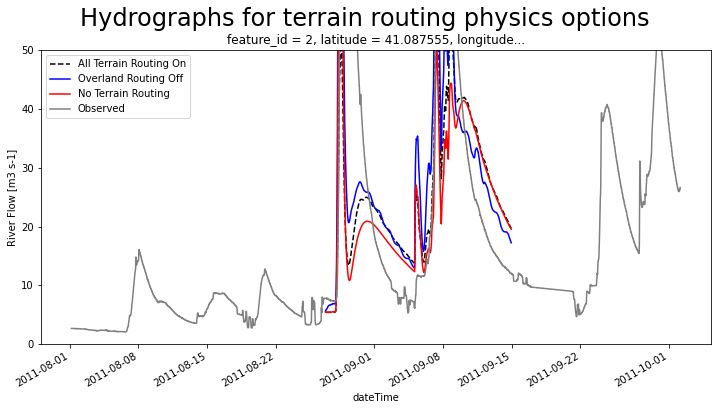

In [82]:
fig, axes = plt.subplots(ncols=1,figsize=(12, 6))
plt.suptitle('Hydrographs for terrain routing physics options',fontsize=24)
chanobs_control.sel(feature_id = 2).streamflow.plot(label='All Terrain Routing On',
                                                        color='black',
                                                        linestyle='--')
chanobs_ov_off.sel(feature_id = 2).streamflow.plot(label='Overland Routing Off',
                                                        color='blue',
                                                        linestyle='-')
chanobs_terrain_off.sel(feature_id = 2).streamflow.plot(label='No Terrain Routing',
                                                        color='red',
                                                        linestyle='-')

obs[obs['site_no'] == '01447720'].plot(x='dateTime',
                                       y='streamflow_cms',
                                       ax=axes,
                                       label='Observed',
                                       color='grey')
plt.ylim(0,50)
plt.legend()
plt.show()

We see definite event differences between the streamflow responses with and without overland routing active (black dashed and blue solid lines). When overland routing is turned off, excess surface runoff from the land model is scraped off the cells and added to the stream directly, so we tend to see earlier and flashier responses to precipitation. The overland routing processes slowdown the runoff and allow water to re-infiltrate where soil storage space is available.

When subsurface routing is also turned off (red solid line), the earlier/flashier peaks are also present, but we lose the secondary pulse and have lower flow after the event. Where is that water going?

**Load the LDASOUT land model output files**

In our simulations, we specified land surface model output (LDASOUT) files every hour. We will read those in using xarray.

In [83]:
ldasout_terrain_on = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson5/run_gridded_baseline/*.LDASOUT*',
                            combine='by_coords')
ldasout_terrain_off = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson5/run_no_terrain_routing/*.LDASOUT*',
                            combine='by_coords')

**Plot the soil moisture states**

Among other variables, the LDASOUT files include soil moisture states (*SOIL_M*) in each of the 4 soil layers. We will select and plot soil moisture in the top soil layer from each simulation at 2011-08-29 00Z. For reference, we also plot the soil types from the model input geogrid file.

In [ ]:
# Select data for 2011-08-29 00Z at surface layer
ldasout_terrain_on_time = ldasout_terrain_on.sel(time = '2011-08-29T00:00:00').sel(soil_layers_stag = 0)
ldasout_terrain_off_time = ldasout_terrain_off.sel(time = '2011-08-29T00:00:00').sel(soil_layers_stag = 0)

# Plot the top layer soil moisture states
fig, axes = plt.subplots(ncols=2,figsize=(15, 6))
plt.subplots_adjust(wspace=0.5)
plt.suptitle('Surface soil moisture states for terrain routing on and off',fontsize=24)
ldasout_terrain_on_time.SOIL_M.plot(ax=axes[0],vmin=0.30,vmax=0.45,cmap='viridis_r')
axes[0].set_title('Terrain routing on')
ldasout_terrain_off_time.SOIL_M.plot(ax=axes[1],vmin=0.30,vmax=0.45,cmap='viridis_r')
axes[1].set_title('Terrain routing off')
plt.show()

In [85]:
# Load the geogrid dataset for reference
geogrid = xr.open_dataset('~/wrf-hydro-training/output/lesson5/run_gridded_baseline/DOMAIN/geo_em.d01.nc')

In [ ]:
# Plot the dominant soil type
fig, axes = plt.subplots(figsize=(6, 6))
geogrid.SCT_DOM.plot(levels=18, cmap='Dark2')
axes.set_title('Soil Type')
plt.show()

The top-level soil moisture state shows significant differences with and without terrain routing active. Overall, we see much more heterogeneity in the "terrain routing on" run (above, left) due to lateral redistribution of water. In the "terrain routing off" run (above, right), soil moisture distribution is largely controlled by vertical soil properties (e.g., saturated hydraulic conductivity, porosity), and you distinctly see the soil type pattern in the soil moisture states.

**Plot the mean soil moisture time series**

In [ ]:
# Calculate the mean bottom-layer soil moisture across the domain
smois_terron_avg = ldasout_terrain_on.SOIL_M.sel(soil_layers_stag = 3).mean(dim=('y','x'))
smois_terroff_avg = ldasout_terrain_off.SOIL_M.sel(soil_layers_stag = 3).mean(dim=('y','x')) 

# Plot the soil moisture time series
fig, axes = plt.subplots(ncols=1,figsize=(12, 6))
plt.suptitle('Average Soil Moisture: Bottom Layer',fontsize=24)
smois_terron_avg.plot(label='Terrain Routing On', color='black', linestyle='-')
smois_terroff_avg.plot(label='Terrain Routing Off', color='red', linestyle='-')
plt.legend()
plt.show()

**Load the GWOUT groundwater bucket model output files**

In [88]:
gwbucket_terrain_on = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson5/run_gridded_baseline/*GWOUT*',
                            combine='by_coords')
gwbucket_terrain_off = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson5/run_no_terrain_routing/*GWOUT*',
                            combine='by_coords')
gwbucket_ov_off = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson5/run_overland_routing_off/*GWOUT*',
                            combine='by_coords')

**Plot the mean groundwater bucket level time series**

Note that groundwater bucket "basins" vary in size, so a simple mean is not a good way to track mass. We do it here for simplicity and to get a general sense of the bucket behavior across the domain.

In [ ]:
# Calculate the mean bucket level across the domain
gwlevel_terron_avg = gwbucket_terrain_on.depth.mean(dim=('feature_id'))
gwlevel_terroff_avg = gwbucket_terrain_off.depth.mean(dim=('feature_id')) 

# Plot the bucket level time series
fig, axes = plt.subplots(ncols=1,figsize=(12, 6))
plt.suptitle('Average Groundwater Bucket Level',fontsize=24)
gwlevel_terron_avg.plot(label='Terrain Routing On', color='black', linestyle='-')
gwlevel_terroff_avg.plot(label='Terrain Routing Off', color='red', linestyle='-')
plt.legend()
plt.show()

In the simplified physics configuration without lateral routing processes, infiltrated water is not permitted to flow laterally. It has to make its way vertically through the 2-meter soil column, then through the deep groundwater "buckets" before it becomes streamflow. These are often much slower flowpaths than lateral flowpaths. Therefore, this water is first wetting up the soil column and the bucket stores, then will eventually make its way to the channel as baseflow.

**IMPORTANT NOTE**: This particular test case has been calibrated to the full terrain routing physics options, so will obviously be sub-optimal for a different physics configuration. You should adjust your parameters to your particular model configuration. You should also re-spinup the model to give it time to adjust to the new physics. We have done neither of those steps in this short example.

## Experiment with Modified Parameters
There are a number of key parameters that impact water partitioning, storage, and movement through the model system. We have pulled many of the most important model parameters into NetCDF files to ease parameter display and manipulation, as well as to allow the parameters to vary independently in space. Key terrain routing parameter files include:
* soil_properties.nc - NoahMP soil and vegetation properties (LSM grid)
* hydro2dtbl.nc - Lateral routing model soil and surface parameters (LSM grid)
* Fulldom_hires.nc - Lateral routing model high-res parameters (routing grid)
* GWBUCKPARM.nc - Groundwater baseflow bucket model parameters (groundwater basin objects)

In this lesson, we will manipulate parameters in the `soil_properties.nc` (*refkdt*, *dksat*, *bexp*, *slope*) and `Fulldom_hires.nc` (*LKSATFAC*, *RETDEPRTFAC*) files.

### Step 1: Create a new template directory and and run default parameter test case
As in the first section, we will make a new simulation directory and use this as a template for creating multiple new simulation directories.

**Step 1a: Create a new template directory for the parameter experiments.**

In [90]:
%%bash
# Make a new directory for our default baseline simulation
mkdir -p ~/wrf-hydro-training/output/lesson5/run_default_template

# Copy our model files to the simulation directory
cp ~/wrf-hydro-training/wrf_hydro_nwm_public/trunk/NDHMS/Run/*.TBL \
~/wrf-hydro-training/output/lesson5/run_default_template
cp ~/wrf-hydro-training/wrf_hydro_nwm_public/trunk/NDHMS/Run/wrf_hydro.exe \
~/wrf-hydro-training/output/lesson5/run_default_template

# Create symbolic links to large domain files
cp -as $HOME/wrf-hydro-training/example_case/FORCING \
~/wrf-hydro-training/output/lesson5/run_default_template
cp -as $HOME/wrf-hydro-training/example_case/Gridded_no_lakes/RESTART \
~/wrf-hydro-training/output/lesson5/run_default_template/RESTART

# Copy the domain/parameter files so we can modify them
cp -r $HOME/wrf-hydro-training/example_case/Gridded_no_lakes/DOMAIN \
~/wrf-hydro-training/output/lesson5/run_default_template/DOMAIN

# Copy namelist files
cp ~/wrf-hydro-training/example_case/Gridded_no_lakes/namelist.hrldas \
~/wrf-hydro-training/output/lesson5/run_default_template
cp ~/wrf-hydro-training/example_case/Gridded_no_lakes/hydro.namelist \
~/wrf-hydro-training/output/lesson5/run_default_template

**Step 1b: Setup and run the default parameter baseline experiment**

We now make a new run directory to run the baseline simulation with default (uncalibrated) parameters.

In [91]:
%%bash
cp -r ~/wrf-hydro-training/output/lesson5/run_default_template \
~/wrf-hydro-training/output/lesson5/run_parameter_baseline

Launch the baseline run and make sure it completes successfully.

In [92]:
%%bash
cd ~/wrf-hydro-training/output/lesson5/run_parameter_baseline
mpirun -np 2 ./wrf_hydro.exe >> run.log 2>&1

In [93]:
%%bash
tail -1 ~/wrf-hydro-training/output/lesson5/run_parameter_baseline/diag_hydro.00000

 The model finished successfully.......


**Step 1c: Plot the hydrograph for the baseline (default) run**

We want to take a quick look at the hydrograph for the default parameter run so we see what behavior we might want to adjust.

In [ ]:
# Pull the channel output files into xarray objects 
chanobs_control = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson5/run_parameter_baseline/*CHANOBS*',
                            combine='by_coords')
obs = pd.read_csv('/home/docker/wrf-hydro-training/example_case/USGS_obs.csv',dtype=str)
obs['dateTime'] = pd.to_datetime(obs['dateTime'])
obs['streamflow_cms'] = pd.to_numeric(obs['streamflow_cms'])

# Plot the baseline hydrograph
fig, axes = plt.subplots(ncols=1,figsize=(12, 6))
plt.suptitle('Hydrographs for parameter experiment',fontsize=24)
chanobs_control.sel(feature_id = 2).streamflow.plot(label='Control',
                                                        color='black',
                                                        linestyle='--')
obs[obs['site_no'] == '01447720'].plot(x='dateTime',
                                       y='streamflow_cms',
                                       ax=axes,
                                       label='Observed',
                                       color='grey')
plt.ylim(0,25)
plt.legend()
plt.show()

### Step 2: Modify NoahMP parameters using NCO tools

We will create a new simulation directory for our parameter manipulation experiment. 

All of the parameter file edits will be done using NCO. NCO (NetCDF Operators, http://nco.sourceforge.net/) is a set of useful utilities to manipulate NetCDF files.

**Step 2a: Setup the parameter experiment run directory**

First make a new run directory where we can start modifying parameter files.

In [97]:
%%bash
cp -r ~/wrf-hydro-training/output/lesson5/run_default_template \
~/wrf-hydro-training/output/lesson5/run_parameter_mods

**Step 2b: Use the NCO command `ncap2` to modify the *slope* parameter values in the `soil_properties.nc` file.**

**SLOPE**

There are a number of Noah/NoahMP model parameters that affect water partitioning. One important parameter that we commonly adjust is *slope*. Originally estimated based on land surface topography (hence the name *slope*), the *slope* parameter actually controls how open or closed the bottom boundary of the soil column is. Values range from 0 to 1, where 0 is a completely closed bottom boundary and 1 is completely open. Lower *slope* values will keep more water in the soil column, while higher values will allow more water to drain to the channel or to deeper baseflow stores, depending on the selected baseflow physics options.

Here we will use the NCO command `ncap2` to increase the *slope* value.

First, we check the current parameter values using `ncdump`.

In [ ]:
%%bash

ncdump -v slope ~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/soil_properties.nc \
| tail -n 10

The default value for *slope* is a global 0.1. We modify the parameter values using `ncap2` to open up the bottom boundary (*slope=0.2*) and increase the deeper baseflow component. We will discuss the baseflow model more in Lesson 5b.

In [99]:
%%bash

ncap2 -O -s "slope=float(slope*0.0+0.2)" \
~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/soil_properties.nc \
~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/soil_properties.nc

We check to make sure the changes are as expected.

In [ ]:
%%bash

ncdump -v slope ~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/soil_properties.nc \
| tail -n 10

**Step 2c: Use the NCO command `ncap2` to modify the *refkdt* parameter values in the `soil_properties.nc` file.**

**REFKDT**

An important Noah/NoahMP parameter that we commonly adjust when activating terrain routing is *refkdt*. *Refkdt* controls how easily precipitation reaching the surface infiltrates into the soil column vs. stays on the surface where it can become surface runoff. Higher values of *refkdt* lead to more infiltration and less surface (fast) runoff. This tunable parameter can be set to a relatively high value (e.g., 3.0) suitable for running the column land surface model only. When activating terrain routing to explicitly model these processes, we often reduce this parameter. In addition, if you are calling the land surface model on a small timestep (e.g., seconds to minutes), you may want to reduce this parameter to compensate for the more frequent calls to the vertical infiltration scheme. 

Here we will use the NCO command `ncap2` to decrease the *refkdt* value.

First, we check the current parameter values using `ncdump`.

In [ ]:
%%bash

ncdump -v refkdt ~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/soil_properties.nc \
| tail -n 10

The default value for *refkdt* is a global 3.0. We modify the parameter values using `ncap2` to a lower value (1.8).

In [ ]:
%%bash

ncap2 -O -s "refkdt=float(refkdt*0.0+1.8)" \
~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/soil_properties.nc \
~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/soil_properties.nc
ncdump -v refkdt ~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/soil_properties.nc \
| tail -n 10

**Step 2d: Use the NCO command `ncap2` to modify the *dksat* parameter values in the `soil_properties.nc` file.**

**DKSAT and BEXP**

As with most physically-based hydrological models, the soil saturated hydraulic conductivity (*dksat*) controls the speed at which water moves through the subsurface. This is a sensitive parameter in the model, and while easy to measure at the point scale, *dksat* is tricky to estimate at the scale of kilometers. Initial values are estimated based on soil texture class, but reported ranges have large (many orders of magnitude) variability. This is a common calibration parameter, along with the related *bexp* parameter that controls how actual conductivity is scaled from saturated conductivity based on soil water content.

Here we will use the NCO command `ncap2` to increase the *dksat* value by a factor of 3 and *bexp* by a factor of 2.

First, we check the current parameter values using `ncdump`.

In [ ]:
%%bash

ncdump -v dksat ~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/soil_properties.nc \
| tail -n 10

Note that this parameter's initial values vary in space based on soil texture class. We modify the parameter values using `ncap2` to increase by a factor of 3. This maintains the spatial distribution, but encourage faster soil water movement overall.

In [ ]:
%%bash

ncap2 -O -s "dksat=float(dksat*3.0)" \
~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/soil_properties.nc \
~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/soil_properties.nc
ncdump -v dksat ~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/soil_properties.nc \
| tail -n 10

Use `ncdump` to check the starting values of *bexp*. Note that these also vary spatially by soil type. We will double these values.

In [ ]:
%%bash

ncdump -v bexp ~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/soil_properties.nc \
| tail -n 10

In [ ]:
%%bash

ncap2 -O -s "bexp=float(bexp*2.0)" \
~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/soil_properties.nc \
~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/soil_properties.nc
ncdump -v bexp ~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/soil_properties.nc \
| tail -n 10

### Step 3: Modify terrain routing parameters using NCO tools

Now we will turn our attention to the parameters that affect lateral routing behavior.

**Step 3a: Use the NCO command `ncap2` to modify the *LKSATFAC* parameter values in the `Fulldom_hires.nc` file**

**LKSATFAC**

The Fulldom_hires.nc file contains two parameters that are also important for lateral flow processes. The *LKSATFAC* parameter is a multiplier on the prescribed lateral saturated hydraulic conductivity values specified in `hydro2dtbl.nc`. By default, lateral conductivity in `hydro2dtbl.nc` matches vertical conductivity specified in `soil_properties.nc`. However, in the real world we frequently see many orders of magnitude higher conductivities in the lateral direction vs. the vertical direction (due to soil stratigraphy, preferential flowpaths caused by roots and animals, etc.). *LKSATFAC* is an easy way to adjust this anisotropy, and by default it is set to 1,000.

We will use the NCO command `ncap2` to increase the *LKSATFAC* value to 2000.

First, we check the current parameter values.

In [ ]:
%%bash

ncdump -v LKSATFAC ~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/Fulldom_hires.nc \
| tail -n 10

Then, we modify the parameter values using `ncap2` and confirm our changes.

In [ ]:
%%bash

ncap2 -O -s "LKSATFAC=float(LKSATFAC*0.0+2000.0)" \
~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/Fulldom_hires.nc \
~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/Fulldom_hires.nc
ncdump -v LKSATFAC ~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/Fulldom_hires.nc \
| tail -n 10

**RETDEPRTFAC**

The *RETDEPRTFAC* parameter is a multiplier on the maximum retention depth. Ponded water on the surface above this retention depth threshold can be moved around the landscape via overland flow. The default value in the code is quite small (~0.001mm, though variable by terrain slope) to allow almost all ponded water to be available for routing. However, in many regions landscape features like wetlands, small detention ponds, and heavy vegetation litter/debris can trap water on the land surface. Increasing the *RETDEPRTFAC* multiplier will hold more ponded water on the surface before it becomes runoff.

We will use the NCO command `ncap2` to increase the *RETDEPRTFAC* value to 10000 (max of 10mm).

First, we check the current parameter values.

In [ ]:
%%bash

ncdump -v RETDEPRTFAC ~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/Fulldom_hires.nc \
| tail -n 10

Then, we modify the parameter values using `ncap2` and confirm our changes.

In [ ]:
%%bash

ncap2 -O -s "RETDEPRTFAC=float(RETDEPRTFAC*0.0+10000.0)" \
~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/Fulldom_hires.nc \
~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/Fulldom_hires.nc
ncdump -v RETDEPRTFAC ~/wrf-hydro-training/output/lesson5/run_parameter_mods/DOMAIN/Fulldom_hires.nc \
| tail -n 10

**Step 3b: Run the simulation**

Now we are ready to run a simulation with our new modified parameters.

In [ ]:
%%bash

cd ~/wrf-hydro-training/output/lesson5/run_parameter_mods
mpirun -np 2 ./wrf_hydro.exe >> run.log 2>&1

Check to make sure your run completed successfully.

In [ ]:
%%bash

tail -1 ~/wrf-hydro-training/output/lesson5/run_parameter_mods/diag_hydro.00000

### Results
We will now look at the differences in streamflow between our baseline run with default parmeters and the simulation using our new modified parameters.

We will use Python and the `xarray` library to load the data and plot hydrographs. For an intro to these tools, please see [Lesson 3](Lesson-3-visualize.ipynb).

**Load the CHANOBS streamflow datasets**

We are going to use the CHANOBS files because it will limit the number of grid cells to only those which we have specified have a gage.

In [113]:
# Pull the channel output files into xarray objects 
chanobs_param_mods = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson5/run_parameter_mods/*CHANOBS*',
                                       combine='by_coords')

**Plot the hydrographs**

In [ ]:
fig, axes = plt.subplots(ncols=1,figsize=(12, 6))
plt.suptitle('Hydrographs for parameter experiment',fontsize=24)
chanobs_control.sel(feature_id = 2).streamflow.plot(label='Control',
                                                    color='black',
                                                    linestyle='--')
chanobs_param_mods.sel(feature_id = 2).streamflow.plot(label='Parameter Modifications',
                                                       color='blue',
                                                       linestyle='-')
obs[obs['site_no'] == '01447720'].plot(x='dateTime',
                                       y='streamflow_cms',
                                       ax=axes,
                                       label='Observed',
                                       color='grey')
plt.ylim(0,30)
plt.legend()
plt.show()

### Discussion
Our baseline simulation with default parameters had an initial peak that was a bit too early and flashy and a muted secondary peak. We increased *slope* to better blend the hydrograph peaks and modified *refkdt* to better match our activated terrain physics. We increased *dksat* and *bexp* (controlling the vertical drainage rate) and *LKSATFAC* (controlling the lateral drainage rate) to add more spread to the flow peak. We increased *RETDEPRTFAC* to hold more ponded water at the surface. Our modified parameter experiment results do better match the gage observations, though we have a delayed peak which might be addressed through additional parameter manipulation (e.g., groundwater parameters).

**IMPORTANT NOTE**: We abbreviated this parameter calibration exercise to fit within a short lesson. In practice, you would want to give the model time to adjust to a new parameter set by running an extended "spin-up" period before the time period you are evaluating. You would also want to expose the model to a wider range of conditions than the short event demostrated here. Model parameters calibrated to a short event may not transfer well to other time periods. Good practice is to calibrate your model to a wide range of conditions to minimize the impacts of forcing, gage, or model physics/parameter uncertainties.

# Next up - Do it yourself!
This concludes Lesson 5. Spend some time creating your own parameter and physics experiments.

The next lesson is [Lesson 6](Lesson-6-lakes.ipynb).

**IT IS BEST TO EITHER SHUTDOWN THIS LESSON OR CLOSE IT BEFORE PROCEEDING TO THE NEXT LESSON TO AVOID POSSIBLY EXCEEDING ALLOCATED MEMORY. Shutdown the lesson be either closing the browser tab for the lesson or selecting `Kernel -> Shut Down Kernel` in JupyterLab.**

© UCAR 2020